In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
BUFFER_SIZE = 10000

def parse(x):
    x = x[:,:,None]
    x = tf.tile(x, (1,1,3))
    x = tf.image.resize(x, (32, 32))
    x = x / (255/2) - 1
    x = tf.clip_by_value(x, -1., 1.)
    return x

def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(BUFFER_SIZE)
    return xy

def load_mnist():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    
    xpriv = make_dataset(x_train, y_train, parse)
    xpub = make_dataset(x_test, y_test, parse)
    
    return xpriv, xpub

xpub, xpriv = load_mnist()

2022-02-07 14:31:26.525126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-07 14:31:28.521153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-02-07 14:31:28.521978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22346 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2022-02-07 14:31:28.522639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

In [3]:
batch_size = 64
id_setup = 4
lr_classify = 0.001
lr_encoder = 0.001
lr_decoder = 0.0001
lr_discriminator = 0.001
gradient_penalty = 500.

iterations = 2000
# log_frequency = 200

In [4]:
def ResBlock(inputs, dim, ks=3, bn=False, activation='relu', reduce=1):
    x = inputs
    
    stride = reduce
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, padding='same')(x)
    
    if reduce > 1:
        inputs = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(inputs)
    
    return inputs + x

def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(xin)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResBlock(x, 64)
    x = ResBlock(x, 128, reduce=2)
    x = ResBlock(x, 128)
    x = ResBlock(x, 256, reduce=2)
    return tf.keras.Model(xin, x)

def make_g(input_shape, class_num):
    xin = tf.keras.layers.Input(input_shape)
    x = xin
    x = ResBlock(xin, 256)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if class_num == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = class_num

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(xin, x)

def make_encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(x)
    return tf.keras.Model(xin, x)

def make_decoder(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation=act)(xin)
    x = tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation=act)(x)
    x = tf.keras.layers.Conv2DTranspose(channels, 3, 2, padding='same', activation="tanh")(x)
    return tf.keras.Model(xin, x)

def make_generator(input_shape, channels=3):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

def make_discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(xin)
    bn = False
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

In [5]:
def get_gradient_penalty(x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = discriminator(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

In [6]:
client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)

input_shape = xpriv.element_spec[0].shape
f = make_f(input_shape)
intermidiate_shape = f.layers[-1].output_shape[1:]
g = make_g(input_shape=intermidiate_shape, class_num=10)
encoder = make_encoder(input_shape=input_shape)
generator = make_generator(input_shape=(4096,))
discriminator = make_discriminator(intermidiate_shape)

f_opt = tf.keras.optimizers.Adam(learning_rate=lr_classify)
encoder_opt = tf.keras.optimizers.Adam(learning_rate=lr_encoder)
decoder_opt = tf.keras.optimizers.Adam(learning_rate=lr_decoder)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=lr_discriminator)

iterator = zip(client_dataset.take(iterations), attacker_dataset.take(iterations))

iter = 1
log = []

for (x_private, label_private), (x_public, label_public) in iterator:
    with tf.GradientTape(persistent=True) as tape:
        z_private = f(x_private, training=True)
        y_pred = g(z_private, training=True)
        c_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=label_private, y_pred=y_pred)

        z_public = encoder(x_public, training=True)

        d_privite_logits = discriminator(z_private, training=True)
        d_public_logits = discriminator(z_public, training=True)

        encoder_loss = -tf.reduce_mean(d_public_logits)

        d_loss = tf.reduce_mean( d_public_logits ) - tf.reduce_mean( d_privite_logits )
        w = float(gradient_penalty)
        gp = get_gradient_penalty(z_private, z_public)
        d_loss += gp * w

    # update f and g:
    var = f.trainable_variables + g.trainable_variables
    gradients = tape.gradient(c_loss, var)
    f_opt.apply_gradients(zip(gradients, var))

    # encoder is updated by f_loss
    var = encoder.trainable_variables
    gradients = tape.gradient(encoder_loss, var)
    encoder_opt.apply_gradients(zip(gradients, var))

    # update discriminator:
    var = discriminator.trainable_variables
    gradients = tape.gradient(d_loss, var)
    discriminator_opt.apply_gradients(zip(gradients, var))

    # Now let's do something with the generatative decoder:
    flat_z_pub = f(x_public, training=False).numpy().reshape((batch_size, 4096))
    for _ in range(20):
        with tf.GradientTape() as tape:
            # x_temp = generator(tf.concat([flat_z_pub, tf.constant(np.random.rand(*(flat_z_pub.shape)).astype("float32"))],1), training=True)
            x_temp = generator(flat_z_pub)
            generator_loss = tf.losses.MeanSquaredError()(x_public, x_temp)
        var = generator.trainable_variables
        gradients = tape.gradient(generator_loss, var)
        decoder_opt.apply_gradients(zip(gradients, var))
    
    # Now we have the generative decoder trained, let's attack original image
    flat_z_priv = z_private.numpy().reshape((batch_size, 4096))
    # rec_x_private = generator(tf.concat([flat_z_priv, tf.constant(np.random.rand(*(flat_z_priv.shape)).astype("float32"))],1), training=True)
    rec_x_private = generator(flat_z_priv, training=False)
    loss_verification = tf.losses.MeanSquaredError()(x_private, rec_x_private)
    log.append(loss_verification)
    print("Iteration {} attack MSE: {}".format(iter, loss_verification.numpy()))
    iter += 1

2022-02-07 14:31:44.173074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-02-07 14:31:45.385764: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-07 14:31:45.389914: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-02-07 14:31:45.389930: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-02-07 14:31:45.390041: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

Iteration 1 attack MSE: 0.36327406764030457
Iteration 2 attack MSE: 0.2821952700614929
Iteration 3 attack MSE: 0.3898443579673767
Iteration 4 attack MSE: 0.6346579790115356
Iteration 5 attack MSE: 0.595247745513916
Iteration 6 attack MSE: 0.5496047735214233
Iteration 7 attack MSE: 0.4779466986656189
Iteration 8 attack MSE: 0.43354469537734985
Iteration 9 attack MSE: 0.41178083419799805
Iteration 10 attack MSE: 0.37615060806274414
Iteration 11 attack MSE: 0.3194231688976288
Iteration 12 attack MSE: 0.3183651566505432
Iteration 13 attack MSE: 0.3008712828159332
Iteration 14 attack MSE: 0.2851161062717438
Iteration 15 attack MSE: 0.2943136692047119
Iteration 16 attack MSE: 0.2926165759563446
Iteration 17 attack MSE: 0.3093728721141815
Iteration 18 attack MSE: 0.32158926129341125
Iteration 19 attack MSE: 0.29806673526763916
Iteration 20 attack MSE: 0.294828325510025
Iteration 21 attack MSE: 0.2607646882534027
Iteration 22 attack MSE: 0.24333611130714417
Iteration 23 attack MSE: 0.246949791

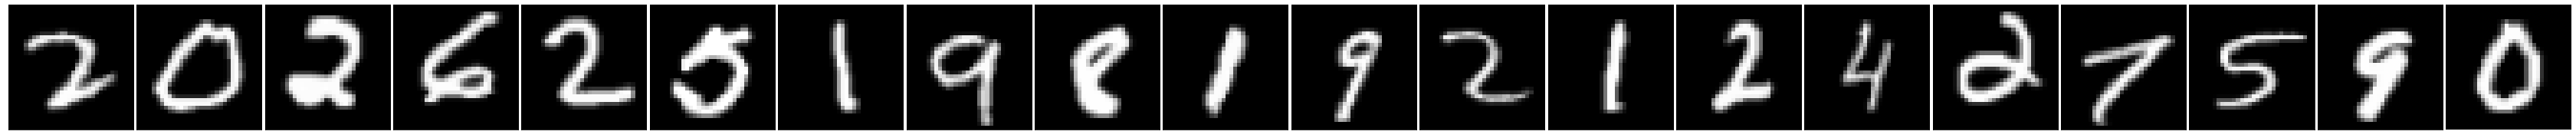

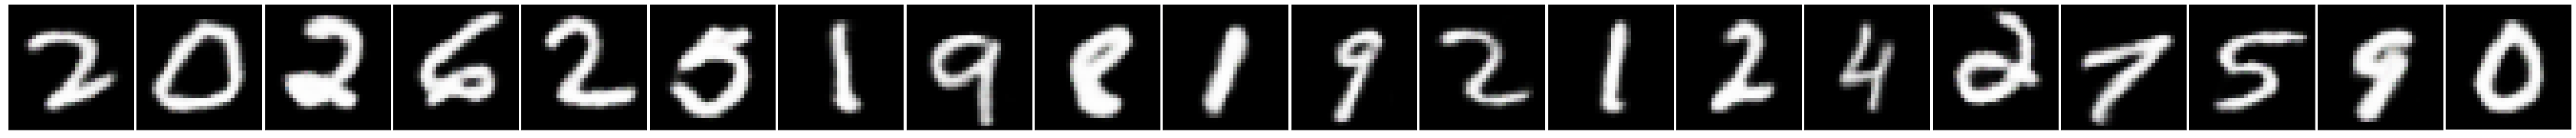

In [7]:
attacked_img = rec_x_private[15:35,:,:,:]
original_img = x_private[15:35,:,:,:]

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig

fig = plot(original_img)
fig = plot(attacked_img)

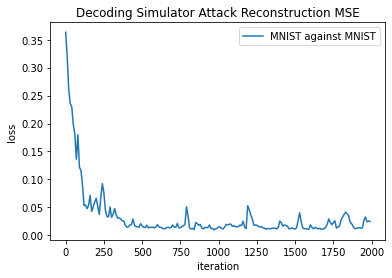

In [12]:
def plot_log(ax, x, y, label=None, color='blue'):
    ax.plot(x, y, color=color)
    ax.grid()
    if label is not None:
        ax.set(title=label)

# from matplotlib.pyplot import figure
# figure(figsize=(9, 5), dpi=160)

# plot the training loss:
log_freq = 10
sampled_log = [log[i*log_freq] for i in range(int(len(log)/log_freq))]
plt.title("Decoding Simulator Attack Reconstruction MSE")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot([i * log_freq for i in range(int(len(log)/log_freq))], sampled_log)
plt.legend(['MNIST against MNIST'], loc='upper right')
plt.show()

In [13]:
np.savetxt('./log/mnist.csv', log, delimiter=',')

Seems all right!

In [15]:
fsha = np.loadtxt("../log/attacks/log_active.csv",delimiter=",")

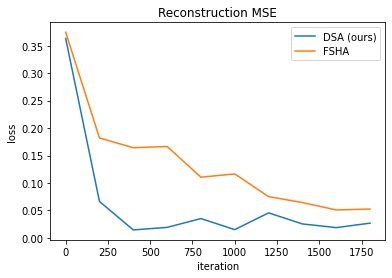

In [26]:
log_freq = 200
sampled_log = [log[i*log_freq] for i in range(int(len(log)/log_freq))]

plt.title("Reconstruction MSE")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot([i * log_freq for i in range(int(len(log)/log_freq))], sampled_log)
plt.plot([i * log_freq for i in range(int(len(log)/log_freq))], fsha[0:10,3])
plt.legend(['DSA (ours)','FSHA'], loc='upper right')
plt.show()